# Objective: 


Learning Source: https://scikit-learn.org/stable/modules/clustering.html

## Tools
### Mean-shift¶
Mean-shift, like  𝑘 -means, is a clustering algorithm with a name that tells us what it does. It works by first calculating the probability that a data point will be present at any point in the n-dimensional space defined by the number of features. You can visualize these probabilities as a surface having hills that "peak" where many data points are present, and flat areas or valleys where few data points are present. The "peaks" represent what will become the cluster means. This surface of probabilities is called a kernel density surface.

Mean-shift is an iterative algorithm. At each iteration, each data point is shifted a tiny bit "up" the nearest hill. If a data point is already at the peak, it stays where it is. Once all data points have reached the point where they are at peaks and all further shifts (if any) are smaller than a given threshold, the algorithm terminates. The data points are then assigned a "cluster" based on their peak.

You may notice that nothing in this definition says how high or big a hill in the surface has to be to qualify as a "peak". Think of mountains circled by smaller foothills – does each foothill count as its own peak, or are they just part of the hill toward the higher mountain peak?

Mean-shift defines peaks using a user-defined input parameter called "bandwidth" that ranges from 0 to 1. Higher bandwidths create a smoother kernel density surface, leading to fewer peaks because smaller hills are smoothed out, whereas lower bandwidths lead to a surface with more peaks – the same peaks spotted by the higher bandwidth, plus some lower peaks.

Mean shift makes no assumptions about the nature of the data or the number of clusters, making it more versatile than  𝑘 -means – though like  𝑘 -means, it creates clusters where data points form an n-dimensional "globe" around a central point. It works for data sets where many clusters are suspected. Again unlike  𝑘 -means, clusters don't have to be the same size, and can have non-flat geometry, meaning clusters based on  𝑚  features that cannot be separated by a straight line or plane in the  𝑚 -dimensional space. You may recall the concept of non-flat geometry from the lesson on the kernel trick used by SVM. However, mean shift is slow (runtime increases with the square of the size of the input) so it is recommended for small to medium-sized datasets only.

Another cool thing about mean shift is that if a point is too far away from the peaks, it may not be assigned to any cluster at all. This will depend on the threshold and number of iterations allowed. All of the other methods we review here, and  𝑘 -means before, will assign all data points to clusters, no matter how poorly suited to clustering some are.

If you don't know how many clusters you are looking for, or you suspect your clusters are heterogeneous in size or shape, and you're working with a small enough data set, mean-shift may be a good choice.

Here are some great animations of mean shift clustering in action.

### Affinity propagation
Affinity Propagation is based on defining exemplars for data points. An exemplar is a data point similar enough to another data point that one could conceivably be represented by the other – they convey largely the same information. Affinity Propagation chooses the number of clusters based on the data, and is often used for parsing images. It tends to select more clusters than other methods, making it better suited to data where many clusters are suspected.

Unlike  𝑘 -means, clusters can be uneven in size. They can also involve non-flat geometry.

Like spectral clustering, affinity propagation begins with an n x n similarity matrix. Again, any similarity computation can be used. However, in this case the similarity between points l and m ( 𝑠(𝑙,𝑚) ) is interpreted to mean how well-suited data point l is to be an exemplar of data point m (and vice-versa). Very similar data points would make good exemplars for one another.

Within the similarity matrix, each data point also has a real number  𝑠(𝑙,𝑙)  indicating that we, the user, would prefer that it be chosen as an exemplar.

In addition, there is a clustering matrix  𝑐  that is also n by n. Within this matrix, entry  𝑐𝑙𝑚  is equal to 1 if  𝑚  is the exemplar of  𝑙  and 0 otherwise. Entry  𝑐𝑚𝑚  will be equal to 1 if m is an exemplar and 0 otherwise.

The goal is to find a matrix composition for c that maximizes the net similarity, measured as the sum of each value of c multiplied by its corresponding value for s:

∑𝑙=1𝑛∑𝑚=1𝑛𝑐𝑙𝑚𝑠(𝑙,𝑚)
 
This is maximized by juggling two parameters. The first is availability, which is sent from candidate exemplars to potential cluster members to quantify how well-suited that point is to be an exemplar. The second is responsibility, which is sent from cluster members to exemplars to quantify how well-suited the data point is to be a member of that exemplar's cluster.

The algorithm iterates by using the current availability information to update the responsibility information, and then using the new responsibility information to update the availability information. It then calculates the net similarity score for the c matrix based on the availability and responsibility information. This iteration algorithm is called the "sum-product algorithm" (because the net similarity score is the sum of products). It has also been called "loopy belief propagation", which is just a fantastic name.

There are two parameters that can be used to "tune" the affinity propagation algorithm to discover more or fewer clusters. The first, _damping_, causes the responsibility and availability calculations to be weighted by the previous responsibility and availability options, making changes slower. This helps to avoid a situation where the calculations consistently "overshoot" the best solution.

The second parameter, _preference_, corresponds to  𝑠(𝑙,𝑙)  and is the user's chance to specify, before the algorithm runs, whether there are certain data points that should be more likely to be chosen as exemplars. If no values are provided, all preference values are set to the median of the similarity values for all data point pairs.

Affinity propagation is not a quick algorithm. The time it takes to run each iteration increases with the square of the input data. It's also memory intensive, with memory needs proportional to the square of the input. For this reason, it works best for small and medium datasets, unless you have a lot of time and computational power.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [2]:
boston_data = "https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv"
    
df = pd.read_csv(boston_data)

In [3]:
df.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [4]:
df.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


In [6]:
df.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'ctz', 'country', 'overall', 'pace', 'state', '30k', '5k',
       'genderdiv', '20k', '35k', 'city', '40k'],
      dtype='object')

In [11]:
df.dtypes
# 'gender', 'bib' 'ctz', 'country' 'state'. '30k', '5k', '20k', '35k' and 'city' are strings

25k           object
age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [12]:
df.nunique()
#68 unique countries;16,137 names; 2 genders (binary);  4,416 cities; 

25k           3245
age             61
name         16137
division      3698
10k           1459
gender           2
half          2761
official      5370
bib          16157
ctz             75
country         68
overall      16107
pace           362
state           65
30k           3862
5k             808
genderdiv     9812
20k           2644
35k           4539
city          4416
40k           5136
dtype: int64

In [13]:
df.iloc[413, :]
#Participant Marathon: Kenichi Kutsukake is from Ibaraki, Japan. He is a male who is 32 years old.His half marathon point is 79.1

25k                           -
age                          32
name         Kutsukake, Kenichi
division                    269
10k                       36.90
gender                        M
half                      79.10
official                    162
bib                         498
ctz                         NaN
country                     JPN
overall                     346
pace                       6.18
state                       NaN
30k                      113.60
5k                        18.42
genderdiv                   325
20k                       74.98
35k                      133.23
city                    Ibaraki
40k                      153.13
Name: 413, dtype: object

In [14]:
df["25k"] = pd.to_numeric(df["25k"], errors="coerce")

In [15]:

df.dtypes

25k          float64
age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [16]:
df["10k"] = pd.to_numeric(df["10k"], errors="coerce")

In [17]:

df[["30k", "5k", "20k", "35k", "40k"]] = df[["30k", "5k", "20k", "35k", "40k"]].apply(pd.to_numeric, errors="coerce")

#df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
#df["5k"] = pd.to_numeric(df["5k"], errors="coerce")
#df["25k"] = pd.to_numeric(df["25k"], errors="coerce")

Text(0.5, 1.0, 'Histogram of Official Finishing Times')

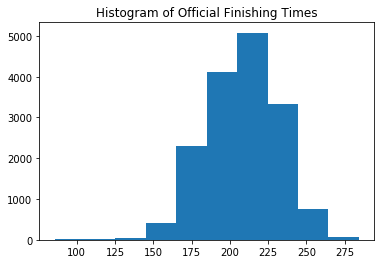

In [19]:
#Plot official times
plt.hist(df["official"])
plt.title("Histogram of Official Finishing Times")

In [20]:
df["official"].describe()

count    16164.000000
mean       208.159470
std         23.743608
min         85.530000
25%        191.727500
50%        209.225000
75%        225.230000
max        284.230000
Name: official, dtype: float64

Text(0.5, 1.0, 'Histogram of Ages')

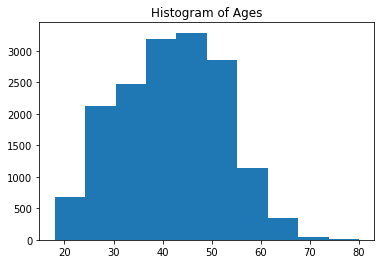

In [21]:
#Plot Age
plt.hist(df["age"])
plt.title("Histogram of Ages")

Text(0.5, 1.0, 'Scatter Plot of Age versus Official Finishing Time')

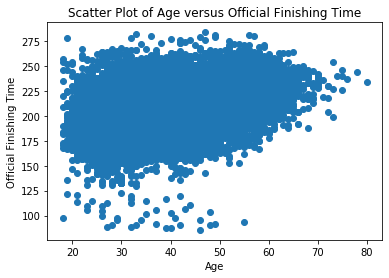

In [22]:
#Plot Age versus Official time for clustering later
plt.scatter(df["age"], df["official"])
plt.xlabel("Age")
plt.ylabel("Official Finishing Time")
plt.title("Scatter Plot of Age versus Official Finishing Time")

In [23]:
df.dtypes

25k          float64
age            int64
name          object
division       int64
10k          float64
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k          float64
5k           float64
genderdiv      int64
20k          float64
35k          float64
city          object
40k          float64
dtype: object

In [24]:
#Code for gender from categorical to numeric
z = {"M": 1, "F": 2}

In [25]:
df["gender"] = df["gender"].map(z)

In [26]:
df["gender"].value_counts()

1    9680
2    6484
Name: gender, dtype: int64

In [27]:
df2 = df.select_dtypes(exclude="object")

In [28]:
X = df.select_dtypes(exclude="object")
X.head()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88


In [29]:
X.isna().sum()

25k          23
age           0
division      0
10k          26
gender        0
official      0
overall       0
pace          0
30k          17
5k           66
genderdiv     0
20k          17
35k          21
40k          17
dtype: int64

In [30]:
X.shape

(16164, 14)

In [31]:
X.head()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88


In [32]:
#Drop null values from df
X = X.dropna()

X.head()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88


In [33]:

#creating 4 different folds of data

offset = int(X.shape[0] / 4)

X1 = X.iloc[:offset]
X2 = X.iloc[offset: (2 * offset)]
X3 = X.iloc[(2 * offset): (3 * offset)]
X4 = X.iloc[(3 * offset):]


In [34]:
from sklearn.preprocessing import normalize

X1 = X1.dropna()
X1 = normalize(X1)

X2 = X2.dropna()
X2 = normalize(X2)

X3 = X3.dropna()
X3 = normalize(X3)

X4 = X4.dropna()
X4 = normalize(X4)

## K-Means Cluster

In [35]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [36]:
Xs = [X1, X2, X3, X4]
n_clusters = [2, 3, 4, 5, 6, 7]

for fold in Xs:
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans = kmeans.fit(fold)
        labels = kmeans.predict(fold)
        print("Fold with {} clusters: ".format(n) , metrics.silhouette_score(fold, labels, metric="euclidean"))
    print("Next Fold")

Fold with 2 clusters:  0.6395190824547817
Fold with 3 clusters:  0.5398851111004441
Fold with 4 clusters:  0.5852729677986471
Fold with 5 clusters:  0.603569665507156
Fold with 6 clusters:  0.5603089364061468
Fold with 7 clusters:  0.5433285330730212
Next Fold
Fold with 2 clusters:  0.7347279293876545
Fold with 3 clusters:  0.7095230370977121
Fold with 4 clusters:  0.5419599781554405
Fold with 5 clusters:  0.5023136466065674
Fold with 6 clusters:  0.45178258345991956
Fold with 7 clusters:  0.4545970068016976
Next Fold
Fold with 2 clusters:  0.7276128083314249
Fold with 3 clusters:  0.5995507672457195
Fold with 4 clusters:  0.6484984961625846
Fold with 5 clusters:  0.6506530424725668
Fold with 6 clusters:  0.517214460245155
Fold with 7 clusters:  0.5057182591489734
Next Fold
Fold with 2 clusters:  0.6565623775006963
Fold with 3 clusters:  0.7019705132889759
Fold with 4 clusters:  0.7045825470334361
Fold with 5 clusters:  0.6347548990565577
Fold with 6 clusters:  0.6119531516269837
Fold 

### Observation of k-Means: 
When there are 2 clusters, the silhouette score is highest for each of the four folds of data (it's a close second in the fourth fold).

In [37]:
from sklearn.cluster import MeanShift, estimate_bandwidth

Xs = [X1, X2, X3, X4]
quantiles = [.1, .2, .3, .4, .5, .6, .65]

for fold in Xs:
    for q in quantiles:
        bandwidth = estimate_bandwidth(fold, quantile=q, n_samples=300)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms = ms.fit(fold)
        labels = ms.labels_
        print("Fold with", len(ms.cluster_centers_),  "clusters with quantile: ", q, ": ", metrics.silhouette_score(fold, labels, metric="euclidean"))
    print("Next Fold")

Fold with 6 clusters with quantile:  0.1 :  0.550670395975054
Fold with 4 clusters with quantile:  0.2 :  0.5705444022451502
Fold with 3 clusters with quantile:  0.3 :  0.6025819097897214
Fold with 3 clusters with quantile:  0.4 :  0.609094802276224
Fold with 3 clusters with quantile:  0.5 :  0.6048446372524304
Fold with 3 clusters with quantile:  0.6 :  0.6080050009696751
Fold with 3 clusters with quantile:  0.65 :  0.6085484252319271
Next Fold
Fold with 6 clusters with quantile:  0.1 :  0.4798959340036934
Fold with 4 clusters with quantile:  0.2 :  0.7089905028672554
Fold with 3 clusters with quantile:  0.3 :  0.7078644652874782
Fold with 3 clusters with quantile:  0.4 :  0.7067459688208233
Fold with 3 clusters with quantile:  0.5 :  0.7348972661381488
Fold with 3 clusters with quantile:  0.6 :  0.7348972661381488
Fold with 3 clusters with quantile:  0.65 :  0.7348972661381488
Next Fold
Fold with 9 clusters with quantile:  0.1 :  0.4725111117616325
Fold with 5 clusters with quantile:

### Observation:
Meanshift findings: For the first two folds, the silhouette coefficient was highest when there were 3 clusters (but with quantiles in bandwidths that differed by .1). The third fold had its strongest silhouette coefficient at 2 clusters. The last fold had the highest silhouette coefficient at 5 clusters.

## Spectral Clustering

In [38]:
from sklearn.cluster import SpectralClustering

Xs = [X1, X2, X3, X4]
n_clusters = [2, 3, 4, 5, 6, 7]

for fold in Xs:
    for n in n_clusters:
        sc = SpectralClustering(n_clusters=n)
        sc = sc.fit(fold)
        labels = sc.labels_
        print("Fold with {} clusters: ".format(n) , metrics.silhouette_score(fold, labels, metric="euclidean"))
    print("Next Fold")

Fold with 2 clusters:  0.6815698992451772
Fold with 3 clusters:  0.5074663903513705
Fold with 4 clusters:  0.5457089475923113
Fold with 5 clusters:  0.5825614283164902
Fold with 6 clusters:  0.45764452483667745
Fold with 7 clusters:  0.5475040303192523
Next Fold
Fold with 2 clusters:  0.7343462958207945
Fold with 3 clusters:  0.7095230370977121
Fold with 4 clusters:  0.4845009219295618
Fold with 5 clusters:  0.4011928389441973
Fold with 6 clusters:  0.48042665578761506
Fold with 7 clusters:  0.4270094222516785
Next Fold
Fold with 2 clusters:  0.7276128083314249
Fold with 3 clusters:  0.609399592720234
Fold with 4 clusters:  0.6105545578977962
Fold with 5 clusters:  0.6319587841173461
Fold with 6 clusters:  0.42497793143828944
Fold with 7 clusters:  0.47573737465499594
Next Fold
Fold with 2 clusters:  0.6565623775006963
Fold with 3 clusters:  0.6974120663378856
Fold with 4 clusters:  0.6997187330953472
Fold with 5 clusters:  0.6655050235700971
Fold with 6 clusters:  0.6032541746582745
F

### Observation Spectral Clustering: 
For the first three folds, the highest silhouette coefficient was produced when there were 2 clusters. For the fourth fold, 2 clusters got the 4th highest silhouette coefficient.

## Analyzing Meanshift Clusters

In [39]:
df2.head()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88


In [40]:
df2.shape

(16164, 14)

In [41]:
df2 = df2.dropna()

In [44]:
df2.shape

(16057, 14)

In [45]:
df3 = normalize(df2)

In [46]:

bandwidth = estimate_bandwidth(df3, quantile=.5, n_samples=300)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit(df3)
labels = ms.labels_

df2["MScluster"] = labels

In [47]:

len(ms.cluster_centers_)

2

In [48]:
ms.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [49]:
df2.head(20)

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55,1
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77,1
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78,1
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43,1
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88,1
5,77.25,28,3,30.88,1,130.47,3,4.98,92.72,15.93,3,61.53,108.70,123.78,1
6,50.50,42,6,18.73,1,90.02,6,3.43,61.63,8.98,6,39.87,74.00,84.67,1
7,77.23,28,6,30.88,1,132.73,6,5.07,92.93,15.90,6,61.52,109.07,125.20,1
8,52.62,49,11,19.77,1,91.78,11,3.50,64.00,9.38,11,41.77,75.95,86.48,1
9,77.25,32,25,30.90,1,141.67,27,5.42,92.77,15.93,27,61.53,111.13,131.98,1


In [50]:
df2[df2["MScluster"] == 0].describe()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster
count,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.000000,15729.00000,15729.000000,15729.000000,15729.000000,15729.0
mean,118.924944,41.845254,1121.151631,47.018152,1.409371,209.453922,8603.502384,7.996773,144.455486,23.565521,4438.15055,94.623967,171.031372,197.788063,0.0
std,11.692287,10.312517,938.634085,4.504247,0.491733,22.064326,4958.981076,0.841672,14.506170,2.254060,2732.32349,9.177334,17.615118,20.752153,0.0
min,88.180000,18.000000,1.000000,33.580000,1.000000,160.170000,291.000000,6.120000,108.020000,16.420000,29.00000,69.450000,128.880000,150.650000,0.0
25%,109.670000,34.000000,388.000000,43.480000,1.000000,193.020000,4318.000000,7.370000,133.120000,21.850000,2158.00000,87.330000,157.450000,182.150000,0.0
50%,119.650000,42.000000,863.000000,47.330000,1.000000,209.880000,8424.000000,8.020000,145.200000,23.700000,4200.00000,95.180000,171.750000,198.450000,0.0
75%,127.530000,49.000000,1578.000000,50.350000,2.000000,225.550000,12757.000000,8.620000,155.080000,25.230000,6361.00000,101.430000,183.900000,212.930000,0.0
max,163.620000,80.000000,3834.000000,66.680000,2.000000,284.230000,17598.000000,10.850000,195.870000,33.220000,10648.00000,131.720000,229.500000,268.400000,0.0


In [51]:

df2[df2["MScluster"] == 1].describe()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.0
mean,84.153963,31.685976,81.731707,33.282866,1.027439,146.062317,124.902439,5.578567,101.892256,16.623720,113.844512,67.180854,120.075244,137.911159,1.0
std,11.446501,7.159318,70.383102,5.032721,0.163608,18.604219,90.261477,0.710261,13.386261,2.680756,83.892699,9.320000,15.243167,17.691806,0.0
min,48.320000,18.000000,1.000000,18.030000,1.000000,85.530000,1.000000,3.270000,59.450000,8.870000,1.000000,38.230000,71.180000,80.550000,1.0
25%,81.560000,26.000000,18.750000,32.315000,1.000000,142.335000,38.000000,5.430000,98.715000,16.090000,33.750000,64.705000,116.707500,134.365000,1.0
50%,88.130000,30.000000,60.500000,35.050000,1.000000,153.945000,118.500000,5.880000,106.480000,17.430000,105.500000,70.310000,125.690000,145.125000,1.0
75%,91.707500,36.000000,142.250000,36.577500,1.000000,157.742500,204.250000,6.022500,110.575000,18.380000,187.250000,73.380000,129.707500,149.080000,1.0
max,102.430000,55.000000,224.000000,38.430000,2.000000,202.400000,290.000000,7.720000,133.920000,21.620000,269.000000,79.630000,167.530000,189.250000,1.0


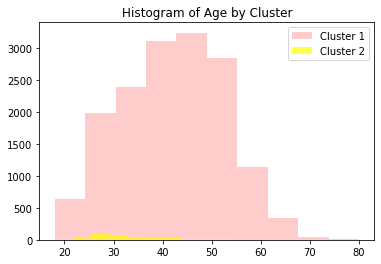

In [52]:
plt.hist(df2[df2["MScluster"] == 0]["age"], color="red", alpha=.2, label="Cluster 1")
plt.hist(df2[df2["MScluster"] == 1]["age"], color="yellow", alpha=.7, label="Cluster 2")
plt.legend()
plt.title("Histogram of Age by Cluster")
plt.show()

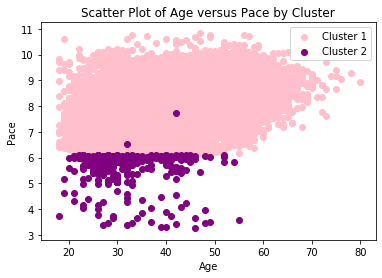

In [53]:

plt.scatter(df2[df2["MScluster"] == 0]["age"], df2[df2["MScluster"] == 0]["pace"], color="pink", label="Cluster 1")
plt.scatter(df2[df2["MScluster"] == 1]["age"], df2[df2["MScluster"] == 1]["pace"], color="purple", label="Cluster 2")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Pace")
plt.title("Scatter Plot of Age versus Pace by Cluster")
plt.show()

## Analyzing k-Means Cluster

In [54]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(df3)
labels = kmeans.predict(df3)
df2["SCcluster"] = kmeans.labels_

In [55]:

df2.head()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster,SCcluster
0,49.87,28,9,18.18,1,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55,1,1
1,77.27,30,5,30.90,1,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77,1,1
2,77.23,23,1,30.90,1,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78,1,1
3,50.50,32,5,18.73,1,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43,1,1
4,48.75,39,3,18.18,1,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88,1,1


In [56]:

df2[df2["SCcluster"] == 0].describe()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster,SCcluster
count,6439.000000,6439.000000,6439.000000,6439.000000,6439.0,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.0,6439.0
mean,125.630523,38.513434,1209.422581,49.648202,2.0,219.777399,10984.390123,8.390544,152.530419,24.891775,3403.955273,99.939795,180.316253,207.828567,0.0,0.0
std,8.778716,9.202383,1069.284293,3.390291,0.0,16.927855,4026.464581,0.645663,10.944425,1.705765,1990.048892,6.884629,13.401291,15.891816,0.0,0.0
min,95.320000,18.000000,1.000000,37.830000,2.0,166.620000,556.000000,6.370000,115.480000,18.850000,29.000000,75.930000,136.150000,157.300000,0.0,0.0
25%,120.240000,31.000000,351.000000,47.580000,2.0,208.680000,8085.500000,7.970000,145.640000,23.870000,1687.500000,95.750000,171.725000,197.480000,0.0,0.0
50%,125.820000,38.000000,844.000000,49.800000,2.0,219.750000,11208.000000,8.380000,152.820000,24.980000,3336.000000,100.100000,180.450000,207.880000,0.0,0.0
75%,131.820000,45.000000,1938.500000,51.920000,2.0,232.110000,14325.500000,8.870000,160.350000,26.000000,5088.500000,104.670000,190.070000,219.480000,0.0,0.0
max,163.620000,74.000000,3834.000000,66.680000,2.0,284.230000,17598.000000,10.850000,195.870000,33.220000,6950.000000,131.720000,227.200000,266.120000,0.0,0.0


In [57]:
df2[df2["SCcluster"] == 1].describe()

,25k,age,division,10k,gender,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,MScluster,SCcluster
count,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.0
mean,113.249949,43.729362,1026.609482,44.788991,1.000936,200.380797,6720.416823,7.650687,137.598007,22.440894,4983.046683,90.129274,163.077644,189.024243,0.034103,1.0
std,12.464529,10.560060,835.655406,4.814582,0.030577,24.484614,4947.211533,0.934066,15.529045,2.409723,3030.393215,9.773815,19.044826,22.887746,0.181502,0.0
min,48.320000,18.000000,1.000000,18.030000,1.000000,85.530000,1.000000,3.270000,59.450000,8.870000,1.000000,38.230000,71.180000,80.550000,0.000000,1.0
25%,105.020000,36.000000,371.000000,41.780000,1.000000,183.022500,2550.250000,6.980000,127.000000,20.970000,2372.250000,83.820000,149.672500,172.700000,0.000000,1.0
50%,112.670000,45.000000,841.000000,44.580000,1.000000,199.125000,5625.000000,7.600000,136.900000,22.370000,4856.500000,89.610000,162.130000,187.720000,0.000000,1.0
75%,121.730000,51.000000,1445.000000,48.050000,1.000000,216.920000,10355.250000,8.280000,148.070000,24.050000,7477.750000,96.730000,175.750000,204.360000,0.000000,1.0
max,158.550000,80.000000,3775.000000,62.580000,2.000000,282.200000,17597.000000,10.770000,191.000000,30.720000,10648.000000,123.180000,229.500000,268.400000,1.000000,1.0


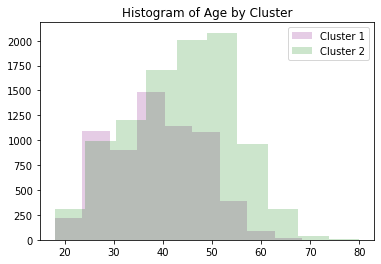

In [61]:
plt.hist(df2[df2["SCcluster"] == 0]["age"], color="purple", alpha=.2, label="Cluster 1")
plt.hist(df2[df2["SCcluster"] == 1]["age"], color="green", alpha=.2, label="Cluster 2")
plt.legend()
plt.title("Histogram of Age by Cluster")
plt.show()

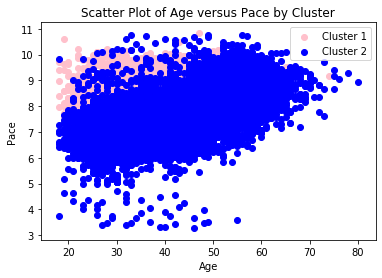

In [60]:
plt.scatter(df2[df2["SCcluster"] == 0]["age"], df2[df2["SCcluster"] == 0]["pace"], color="pink", label="Cluster 1")
plt.scatter(df2[df2["SCcluster"] == 1]["age"], df2[df2["SCcluster"] == 1]["pace"], color="blue", label="Cluster 2")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Pace")
plt.title("Scatter Plot of Age versus Pace by Cluster")
plt.show()

### Conclusion:

Conclusion: As seen in both k-Means clustering and Meanshift clustering, the runners in the Boston Marathon can be broken into two clusters. One cluster consists of the elite runners while the other is comprised of everyone else. According to Meanshift clustering, the elite runners are younger. They also tend to be women. The number of elite runners makes up only 2% of all Boston Marathon Runners.